In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
from torch import nn
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(0)

cuda


In [2]:
# Import custom modules
from data_utils import construct_loader
from model_utils import GNN
from train_test_utils import Standardizer, train_epoch, train_epoch_without_SSL, pred, pred_with_TTA, embeddings_with_TTA

# Training

In [ ]:
batch_size = 512
epochs = 20

train_hyperparam_opt = False # Optional optimization of training and testing hyperparameters
test_hyperparam_opt = False # Optional optimization of testing hyperparameters

# If wanted, we can load an already trained model
save_model = False  # Set to False if you don't want to save
load_trained_model = True  # Set to True to skip training and load existing model
save_plots = False

### Loading and preprocessing the Data

In [4]:
data_df = pd.read_csv("data/AqSolDBc.csv")
# Drop single atoms    
idx_single = [i for i,s in enumerate(data_df['SmilesCurated']) if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or '.' in s]
data_df = data_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

test_df = pd.read_csv("data/OChemUnseen.csv")
# Drop some Nonetypes
idx_nonetype = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s) is None] # Got an error for a SMILES which was None
test_df = test_df.drop(idx_nonetype)
if len(idx_nonetype) > 0:
    print(f"Removing {idx_nonetype} due to Nonetypes")

# Drop single atoms
idx_single = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s).GetNumAtoms() == 1 or '.' in s]
test_df = test_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

Removing [1263, 1444, 3605, 3702] due to single atoms


[17:09:46] Explicit valence for atom # 1 P, 6, is greater than permitted


Removing [667] due to Nonetypes
Removing [471, 503, 589, 591, 592, 593, 594, 610, 613, 641, 643, 647, 649, 652, 653, 654, 656, 658, 676, 681, 693, 744, 759, 763, 769, 773, 777, 807, 809, 811, 813, 869, 902, 969, 998] due to single atoms


In [5]:
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_loader = construct_loader(train_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=True, batch_size=batch_size)
val_loader = construct_loader(val_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=False, batch_size=batch_size)
test_loader = construct_loader(test_df, 'SMILES', 'LogS', shuffle=False, batch_size=1)
print(f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

# Standardizer for the solubility labels
mean = np.mean(train_loader.dataset.labels)
std = np.std(train_loader.dataset.labels)
stdzer = Standardizer(mean, std)

Precomputing data...
Precomputation finished. 7238 molecules cached.
Precomputing data...
Precomputation finished. 805 molecules cached.
Precomputing data...
Precomputation finished. 2215 molecules cached.
Train size: 7238, Val size: 805, Test size: 2215


### Hyperparameter optimization

In [ ]:
# Optional hyperparameter optimization on the validation set

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    alpha = trial.suggest_float("alpha", 0.3, 0.7, step=0.1) # Weighting the losses of the two tasks
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    depth = trial.suggest_int("depth", 3, 6, step=1)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features, hidden_size=hidden_size, depth=depth, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss = nn.MSELoss(reduction='mean')

    # By default, we train for a fourth of the epochs used in the main training to get a rough estimate
    for epoch in range(epochs//2):
        train_epoch(model, train_loader, optimizer, loss, alpha, stdzer)

        preds = pred(model, val_loader, mode="predict", stdzer=stdzer)
        rmse_pred = root_mean_squared_error(preds, val_loader.dataset.labels)

        trial.report(rmse_pred, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return rmse_pred

In [ ]:
# Takes about half an hour on my machine for a setting of 20 epochs
if train_hyperparam_opt:    
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner(), study_name="hyperparam_opt")
    study.optimize(objective, n_trials=40, n_jobs=4)

    print(f"Best learning rate: {study.best_params['learning_rate']:.4f}")
    print(f"Best alpha: {study.best_params['alpha']:.4f}")
    print(f"Best hidden size: {study.best_params['hidden_size']:.4f}")
    print(f"Best depth: {study.best_params['depth']:.4f}")
    print(f"Best dropout: {study.best_params['dropout']:.4f}")
    print(f"Best weight decay: {study.best_params['weight_decay']:.4f}")

    study_results = study.trials_dataframe()
    study_results.to_csv("data/hyperparam_opt.csv", index=False)
    print("Study results saved to hyperparam_opt.csv")

    learning_rate = study.best_params['learning_rate']
    alpha = study.best_params['alpha']
    hidden_size = study.best_params['hidden_size']
    depth = study.best_params['depth']
    dropout = study.best_params['dropout']
    weight_decay = study.best_params['weight_decay']

    torch.cuda.empty_cache()

# Standard hyperparameters are the result of a previous hyperparameter optimization
else:
    learning_rate = 0.0025
    alpha = 0.3 # Weighting the losses of the two tasks, smaller alpha means less weight on the denoising task
    hidden_size = 64
    depth = 4
    dropout = 0.2
    weight_decay = 6e-6

[I 2025-04-24 17:10:10,066] A new study created in memory with name: hyperparam_opt
[I 2025-04-24 17:17:01,014] Trial 0 finished with value: 1.2989004430114315 and parameters: {'learning_rate': 0.0018565620482891853, 'alpha': 0.7, 'hidden_size': 128, 'depth': 4, 'dropout': 0.2, 'weight_decay': 7.903247455685373e-06}. Best is trial 0 with value: 1.2989004430114315.
[I 2025-04-24 17:17:02,595] Trial 2 finished with value: 1.182588538673628 and parameters: {'learning_rate': 0.002339738525247744, 'alpha': 0.4, 'hidden_size': 256, 'depth': 5, 'dropout': 0.5, 'weight_decay': 2.5066484779391904e-06}. Best is trial 2 with value: 1.182588538673628.
[I 2025-04-24 17:17:04,889] Trial 3 finished with value: 1.8054748172532857 and parameters: {'learning_rate': 0.0001121642746073204, 'alpha': 0.7, 'hidden_size': 256, 'depth': 5, 'dropout': 0.30000000000000004, 'weight_decay': 1.2324761375555238e-06}. Best is trial 2 with value: 1.182588538673628.
[I 2025-04-24 17:17:13,316] Trial 1 finished with val

Best learning rate: 0.0025
Best alpha: 0.3000
Best hidden size: 64.0000
Best depth: 4.0000
Best dropout: 0.2000
Best Weight decay: 0.0000
Study results saved to hyperparam_opt.csv


### Training on both Tasks

In [8]:
model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features, 
            hidden_size=hidden_size, depth=depth, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss = nn.MSELoss(reduction='mean')
print('\n', model, '\n')


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=64, bias=True)
    (convs): ModuleList(
      (0-3): 4 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=108, out_features=64, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=64, out_features=64, bias=True)
    (ffn2): Linear(in_features=64, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (node_lin): Linear(in_features=64, out_features=44, bias=True)
    (edge_lin): Linear(in_features=64, out_features=7, bias=True)
  )
) 



In [9]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path))
    best_model = deepcopy(model).to(device)
    # Skip training
    epochs = 0

In [10]:
# Training the model on both tasks simultaneously
if not load_trained_model:
    best_model = deepcopy(model).to(device)
    best_pred_val_loss = 1e5

    total_train_loss_list = []
    denoise_train_loss_list = []
    pred_train_loss_list = []

    total_val_loss_list = []
    denoise_val_loss_list = []
    pred_val_loss_list = []

    if epochs == 0:
        print("Skipping training, previously trained model was loaded.")

    for epoch in range(0, epochs):
        total_train_loss, denoise_train_loss, pred_train_loss = train_epoch(model, train_loader, optimizer, loss, alpha=alpha, stdzer=stdzer)

        denoised = pred(model, val_loader, mode='denoise', stdzer=stdzer)
        node_feature_targets = [feature for batch in val_loader for feature in batch.x.cpu().flatten().tolist()]
        edge_feature_targets = [feature for batch in val_loader for feature in batch.edge_attr.cpu().flatten().tolist()]
        denoise_val_loss = root_mean_squared_error(denoised, node_feature_targets + edge_feature_targets)

        preds = pred(model, val_loader, mode='predict', stdzer=stdzer)
        pred_val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)
        total_val_loss = alpha * denoise_val_loss + (1 - alpha) * pred_val_loss

        print(f"Epoch {epoch}  Train Total Loss: {total_train_loss:.3f}  Train Denoise Loss: {denoise_train_loss:.3f}  Train Pred Loss: {pred_train_loss:.3f}  Val Total Loss: {total_val_loss:.3f}  Val Denoise Loss: {denoise_val_loss:.3f}  Val Pred Loss: {pred_val_loss:.3f}")

        total_train_loss_list.append(total_train_loss)
        denoise_train_loss_list.append(denoise_train_loss)
        pred_train_loss_list.append(pred_train_loss)
        denoise_val_loss_list.append(denoise_val_loss)
        pred_val_loss_list.append(pred_val_loss)
        total_val_loss_list.append(total_val_loss)

        if pred_val_loss < best_pred_val_loss:
            best_model = deepcopy(model).to(device)
            best_pred_val_loss = pred_val_loss
            
            # Save the best model
            if save_model:
                print(f"Saving best model based on Val Pred Loss...")
                torch.save(best_model.state_dict(), os.path.join("trained_models", f"model.pt"))

Epoch 0  Train Total Loss: 0.055  Train Denoise Loss: 0.039  Train Pred Loss: 0.039  Val Total Loss: 1.526  Val Denoise Loss: 0.421  Val Pred Loss: 1.999
Saving best model based on Val Pred Loss...
Epoch 1  Train Total Loss: 0.037  Train Denoise Loss: 0.016  Train Pred Loss: 0.033  Val Total Loss: 1.356  Val Denoise Loss: 0.393  Val Pred Loss: 1.768
Saving best model based on Val Pred Loss...
Epoch 2  Train Total Loss: 0.032  Train Denoise Loss: 0.014  Train Pred Loss: 0.029  Val Total Loss: 1.212  Val Denoise Loss: 0.374  Val Pred Loss: 1.571
Saving best model based on Val Pred Loss...
Epoch 3  Train Total Loss: 0.029  Train Denoise Loss: 0.014  Train Pred Loss: 0.026  Val Total Loss: 1.128  Val Denoise Loss: 0.368  Val Pred Loss: 1.454
Saving best model based on Val Pred Loss...
Epoch 4  Train Total Loss: 0.027  Train Denoise Loss: 0.013  Train Pred Loss: 0.024  Val Total Loss: 1.060  Val Denoise Loss: 0.369  Val Pred Loss: 1.356
Saving best model based on Val Pred Loss...
Epoch 5  T

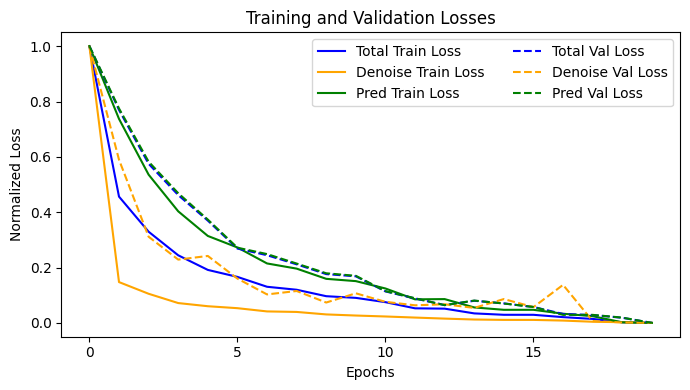

In [11]:
# Only plot if actual training was done
if epochs != 0:

    def normalize_losses(loss_list):
        # Normalize losses to [0, 1]
        min_val, max_val = min(loss_list), max(loss_list)
        return [(loss - min_val) / (max_val - min_val) for loss in loss_list]

    total_train_loss_list_norm = normalize_losses(total_train_loss_list)
    denoise_train_loss_list_norm = normalize_losses(denoise_train_loss_list)
    pred_train_loss_list_norm = normalize_losses(pred_train_loss_list)
    total_val_loss_list_norm = normalize_losses(total_val_loss_list)
    denoise_val_loss_list_norm = normalize_losses(denoise_val_loss_list)
    pred_val_loss_list_norm = normalize_losses(pred_val_loss_list)

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    # Plot normalized losses
    ax.plot(list(range(epochs)), total_train_loss_list_norm, label='Total Train Loss', color='blue')
    ax.plot(list(range(epochs)), denoise_train_loss_list_norm, label='Denoise Train Loss', color='orange')
    ax.plot(list(range(epochs)), pred_train_loss_list_norm, label='Pred Train Loss', color='green')
    ax.plot(list(range(epochs)), total_val_loss_list_norm, label='Total Val Loss', color='blue', linestyle='dashed')
    ax.plot(list(range(epochs)), denoise_val_loss_list_norm, label='Denoise Val Loss', color='orange', linestyle='dashed')
    ax.plot(list(range(epochs)), pred_val_loss_list_norm, label='Pred Val Loss', color='green', linestyle='dashed')
    ax.set_title('Training and Validation Losses')
    ax.legend(ncol=2)
    ax.set_xlabel('Epochs')
    ax.set_xticks(list(range(0, epochs, 5)))
    ax.set_ylabel('Normalized Loss')

    plt.tight_layout()
    if save_plots:   
        fig.savefig("figures/loss_plot.jpg", dpi=300)
    plt.show()

### Training without SSL for reference

In [12]:
model_non_SSL = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features, hidden_size=hidden_size, depth=depth, dropout=dropout).to(device)
optimizer_non_SSL = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_non_SSL = nn.MSELoss(reduction='mean')
print('\n', model, '\n')


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=64, bias=True)
    (convs): ModuleList(
      (0-3): 4 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=108, out_features=64, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=64, out_features=64, bias=True)
    (ffn2): Linear(in_features=64, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (node_lin): Linear(in_features=64, out_features=44, bias=True)
    (edge_lin): Linear(in_features=64, out_features=7, bias=True)
  )
) 



In [13]:
# If wanted, we can load an already trained model

# Path for the best model
model_path = os.path.join("trained_models", "model_non_SSL.pt")
if load_trained_model and os.path.exists(model_path):
    # Load pretrained model
    print(f"Loading model from {model_path}")
    model_non_SSL.load_state_dict(torch.load(model_path))
    best_model_non_SSL = deepcopy(model_non_SSL).to(device)
    # Skip training
    epochs = 0

In [14]:
best_model_non_SSL = deepcopy(model_non_SSL).to(device)
best_val_loss = 1e5

train_loss_list = []
val_loss_list = []

if epochs == 0:
    print("Skipping training, previously trained model was loaded.")

for epoch in range(0, epochs):
    train_loss = train_epoch_without_SSL(model_non_SSL, train_loader, optimizer_non_SSL, loss_non_SSL, alpha=alpha, stdzer=stdzer)

    preds = pred(model_non_SSL, val_loader, mode='predict', stdzer=stdzer)
    val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.2f}  Val Loss: {val_loss:.2f}")

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_model_non_SSL = deepcopy(model_non_SSL).to(device)
        best_val_loss = val_loss
        
        # Save the best model
        if save_model:
            print(f"Saving best model...")
            torch.save(best_model_non_SSL.state_dict(), os.path.join("trained_models", f"model_non_SSL.pt"))

Epoch 0  Train Loss: 0.04  Val Loss: 2.32
Saving best model...
Epoch 1  Train Loss: 0.04  Val Loss: 2.32
Saving best model...
Epoch 2  Train Loss: 0.04  Val Loss: 2.32
Epoch 3  Train Loss: 0.04  Val Loss: 2.32
Epoch 4  Train Loss: 0.04  Val Loss: 2.32
Epoch 5  Train Loss: 0.04  Val Loss: 2.32
Epoch 6  Train Loss: 0.04  Val Loss: 2.32
Epoch 7  Train Loss: 0.04  Val Loss: 2.32
Epoch 8  Train Loss: 0.04  Val Loss: 2.32
Saving best model...
Epoch 9  Train Loss: 0.04  Val Loss: 2.32
Epoch 10  Train Loss: 0.04  Val Loss: 2.32
Epoch 11  Train Loss: 0.04  Val Loss: 2.32
Epoch 12  Train Loss: 0.04  Val Loss: 2.32
Epoch 13  Train Loss: 0.04  Val Loss: 2.32
Epoch 14  Train Loss: 0.04  Val Loss: 2.32
Epoch 15  Train Loss: 0.04  Val Loss: 2.32
Epoch 16  Train Loss: 0.04  Val Loss: 2.32
Epoch 17  Train Loss: 0.04  Val Loss: 2.32
Epoch 18  Train Loss: 0.04  Val Loss: 2.32
Epoch 19  Train Loss: 0.04  Val Loss: 2.32


# Prediction

In [15]:
# Optional hyperparameter optimization on the validation set for the TTA step

def objective(trial):
    learning_rate_TTA = trial.suggest_float("learning_rate_TTA", 1e-5, 1.0, log=True)
    
    preds_TTA = pred_with_TTA(best_model, val_loader, lr=learning_rate_TTA, stdzer=stdzer)

    return root_mean_squared_error(preds_TTA, val_loader.dataset.labels)

In [ ]:
if test_hyperparam_opt:    
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner(), study_name="TTA_hyperparam_opt")
    study.optimize(objective, n_trials=30, n_jobs=6)

    print(f"Best TTA learning rate: {study.best_params['learning_rate_TTA']:.5f}")

    study_results = study.trials_dataframe()
    study_results.to_csv("data/TTA_hyperparam_opt.csv", index=False)
    print("Study results saved to TTA_hyperparam_opt.csv")

    learning_rate_TTA = study.best_params['learning_rate_TTA']

# Standard hyperparameters are the result of a previous hyperparameter optimization
else:
    learning_rate_TTA = 0.00036 # It seems as the best TTA learning rate is about a tenth of the training learning rate

[I 2025-04-24 17:45:08,710] A new study created in memory with name: TTA_hyperparam_opt
[I 2025-04-24 17:45:12,561] Trial 3 finished with value: 1.0397939295558074 and parameters: {'learning_rate_TTA': 0.0022873517777588855}. Best is trial 3 with value: 1.0397939295558074.
[I 2025-04-24 17:45:12,599] Trial 2 finished with value: 0.9718029831574908 and parameters: {'learning_rate_TTA': 0.00010742225315602945}. Best is trial 2 with value: 0.9718029831574908.
[I 2025-04-24 17:45:12,645] Trial 1 finished with value: 69.03695756487575 and parameters: {'learning_rate_TTA': 0.059424976228662975}. Best is trial 2 with value: 0.9718029831574908.
[I 2025-04-24 17:45:12,645] Trial 5 finished with value: 0.9722098859793324 and parameters: {'learning_rate_TTA': 4.633605234393179e-05}. Best is trial 2 with value: 0.9718029831574908.
[I 2025-04-24 17:45:12,661] Trial 4 finished with value: 0.972267630035099 and parameters: {'learning_rate_TTA': 5.249740053845176e-05}. Best is trial 2 with value: 0.97

Best TTA learning rate: 0.00036
Study results saved to TTA_hyperparam_opt.csv


In [17]:
# Prediction with non-SSL model
val_preds_non_SSL = pred(best_model_non_SSL, val_loader, mode='predict', stdzer=stdzer)
test_preds_non_SSL = pred(best_model_non_SSL, test_loader, mode='predict', stdzer=stdzer)
print('Reference results for model trained without SSL:')
print(f"Validation Set RMSE: {root_mean_squared_error(val_preds_non_SSL, val_loader.dataset.labels):.4f}")
print(f"Test Set RMSE: {root_mean_squared_error(test_preds_non_SSL, test_loader.dataset.labels):.4f}")

Reference results for model trained without SSL:
Validation Set RMSE: 2.3241
Test Set RMSE: 2.6415


In [18]:
# Prediction with SLL model without TTA
val_preds = pred(best_model, val_loader, mode='predict', stdzer=stdzer)
test_preds = pred(best_model, test_loader, mode='predict', stdzer=stdzer)
print('Results without TTA:')  
print(f"Validation Set RMSE: {root_mean_squared_error(val_preds, val_loader.dataset.labels):.4f}")
print(f"Test Set RMSE: {root_mean_squared_error(test_preds, test_loader.dataset.labels):.4f}")

Results without TTA:
Validation Set RMSE: 0.9725
Test Set RMSE: 1.3772


In [19]:
# Prediction with SLL model with TTA
# Takes about three times as long as prediction without TTA
val_preds_TTA = pred_with_TTA(best_model, val_loader, lr=learning_rate_TTA, stdzer=stdzer)
test_preds_TTA = pred_with_TTA(best_model, test_loader, lr=learning_rate_TTA, stdzer=stdzer)
print('Results on with TTA:')
print(f"Validation Set RMSE: {root_mean_squared_error(val_preds_TTA, val_loader.dataset.labels):.4f}")
print(f"Test Set RMSE: {root_mean_squared_error(test_preds_TTA, test_loader.dataset.labels):.4f}")

Results on with TTA:
Validation Set RMSE: 0.9723
Test Set RMSE: 1.3772


# Analysis

### Getting the Embeddings

In [20]:
best_model = best_model.to(device)

# Getting embeddings for analysis using PCA
# The embeddings are lists of length "samples" of vectors with length "hidden_size"
train_embeddings = []
for batch in train_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    train_embeddings.extend(embedding.cpu().detach().numpy())

val_embeddings = []
for batch in val_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    val_embeddings.extend(embedding.cpu().detach().numpy())

test_embeddings = []
for batch in test_loader:
    batch = batch.to(device)
    embedding = best_model.get_embedding(batch)
    test_embeddings.extend(embedding.cpu().detach().numpy())

# Create and fit PCA
pca = PCA(n_components=2)
train_embeddings_2d = pca.fit_transform(np.array(train_embeddings))
val_embeddings_2d = pca.transform(np.array(val_embeddings))
test_embeddings_2d = pca.transform(np.array(test_embeddings))
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Also getting the test set embeddings after TTA
test_embeddings_with_TTA = embeddings_with_TTA(best_model, test_loader, lr=learning_rate_TTA)
test_embeddings_with_TTA_2d = pca.transform(np.array(test_embeddings_with_TTA))

Explained variance ratio: [0.5705714  0.15065609]


### Analyzing the Solubility Distribution

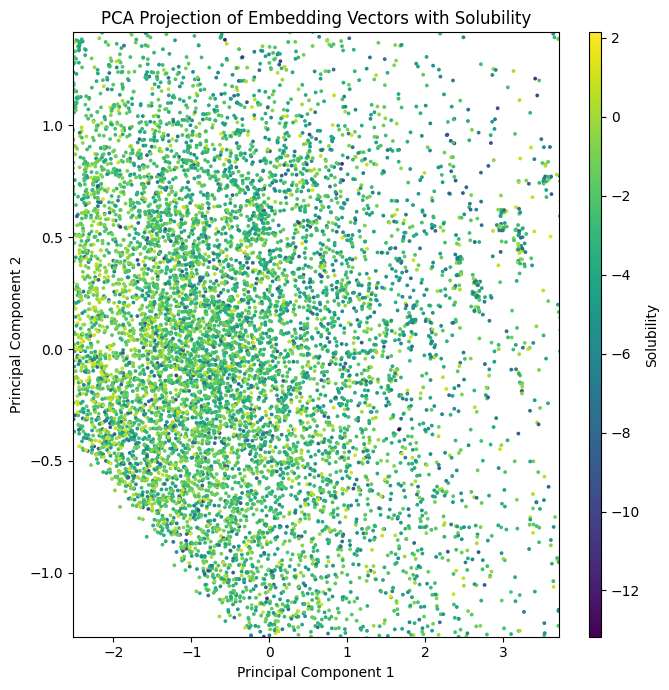

In [21]:
# Get the solubility values from each dataset
train_solubility = train_loader.dataset.labels
val_solubility = val_loader.dataset.labels
test_solubility = test_loader.dataset.labels

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define a consistent colormap for solubility
cmap = plt.cm.viridis
norm = plt.Normalize(min(min(train_solubility), min(val_solubility), min(test_solubility)),
                     max(max(train_solubility), max(val_solubility), max(test_solubility)))

# Plot all datasets on the same axes with different markers
sc1 = ax.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], 
                c=train_solubility, cmap=cmap, norm=norm, s=3)
sc2 = ax.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], 
                c=val_solubility, cmap=cmap, norm=norm, s=3)
sc3 = ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], 
                c=test_solubility, cmap=cmap, norm=norm, s=3)

# Add a colorbar, title, labels, and legend
cbar = fig.colorbar(sc1, ax=ax, aspect=50)
cbar.set_label('Solubility')
ax.set_title('PCA Projection of Embedding Vectors with Solubility')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Dynamically adjust the limits to focus on the main data distribution
# Use percentiles to avoid sensitivity to outliers
x_min_train, x_max_train = np.percentile(train_embeddings_2d[:, 0], [5, 95])
y_min_train, y_max_train = np.percentile(train_embeddings_2d[:, 1], [5, 95])
x_min_test, x_max_test = np.percentile(test_embeddings_2d[:, 0], [5, 95])
y_min_test, y_max_test = np.percentile(test_embeddings_2d[:, 1], [5, 95])
x_max = max(x_max_train, x_max_test)
x_min = min(x_min_train, x_min_test)
y_max = max(y_max_train, y_max_test)
y_min = min(y_min_train, y_min_test)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
if save_plots:  
    fig.savefig("figures/pca_solubility.jpg", dpi=300)
plt.show()

### Analyzing the Class Distribution and Effect of TTA

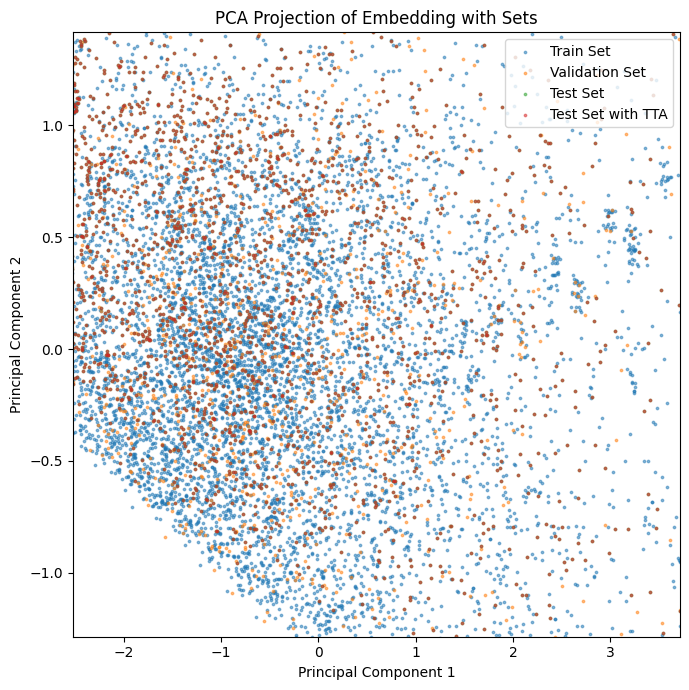

In [24]:
# Plot the 2D embeddings using fig, ax
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], alpha=0.5, label='Train Set', s=3)
ax.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], alpha=0.5, label='Validation Set', s=3)
ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5, label='Test Set', s=3)
ax.scatter(test_embeddings_with_TTA_2d[:, 0], test_embeddings_with_TTA_2d[:, 1], alpha=0.5, label='Test Set with TTA', s=3)

# Calculate centroids with median insetad of mean since we have outliers
train_centroid = np.median(train_embeddings_2d, axis=0)
val_centroid = np.median(val_embeddings_2d, axis=0)
test_centroid = np.median(test_embeddings_2d, axis=0)
test_tta_centroid = np.median(test_embeddings_with_TTA_2d, axis=0)

ax.legend()
ax.set_title('PCA Projection of Embedding with Sets')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
if save_plots:  
    fig.savefig("figures/pca_sets.jpg", dpi=300)
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_14912\3299690885.py:7: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(train_centroid[0], train_centroid[1], s=150,
C:\Users\phili\AppData\Local\Temp\ipykernel_14912\3299690885.py:9: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(val_centroid[0], val_centroid[1], s=150,
C:\Users\phili\AppData\Local\Temp\ipykernel_14912\3299690885.py:11: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(test_centroid[0], test_centroid[1], s=150,
C:\Users\phili\AppData\Local\Temp\ipykernel_14912\3

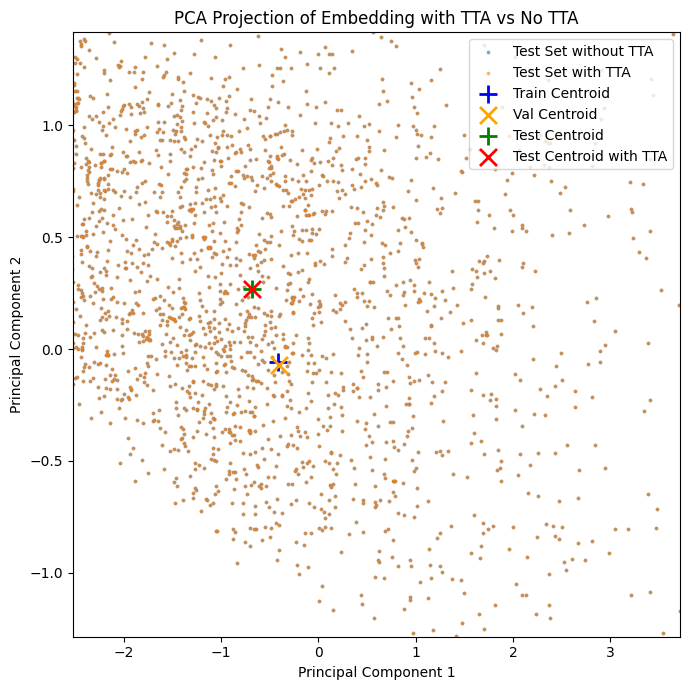

In [ ]:
# Plot the 2D embeddings using fig, ax
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5, label='Test Set without TTA', s=3)
ax.scatter(test_embeddings_with_TTA_2d[:, 0], test_embeddings_with_TTA_2d[:, 1], alpha=0.5, label='Test Set with TTA', s=3)

# Plot centroids with larger markers
ax.scatter(train_centroid[0], train_centroid[1], s=150, 
           c='blue', marker='+', edgecolors='white', linewidths=2, label='Train Centroid')
ax.scatter(val_centroid[0], val_centroid[1], s=150, 
           c='orange', marker='x', edgecolors='black', linewidths=2, label='Val Centroid')
ax.scatter(test_centroid[0], test_centroid[1], s=150, 
           c='green', marker='+', edgecolors='black', linewidths=2, label='Test Centroid')
ax.scatter(test_tta_centroid[0], test_tta_centroid[1], s=150, 
           c='red', marker='x', edgecolors='black', linewidths=2, label='Test Centroid with TTA')

ax.legend()
ax.set_title('PCA Projection of Embedding with TTA vs No TTA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
fig.savefig("figures/pca_sets_TTA_vs_no_TTA.jpg", dpi=300)
plt.show()